In [11]:
import logging
import pprint
import time
import datetime

import tensorflow as tf
import keras as keras
import sklearn.model_selection
import sklearn.datasets
import numpy as np
import typing
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil



In [12]:
import logging
logging.basicConfig()
log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)


# Setup

## Globals

In [13]:
default_params = {
  "optimizer" : "SGD",
  "batch_size" : 64,
  "activation_function" : "relu",
  "layer_sizes" : [4]
}

## Data

In [14]:
X_mc,y_mc = sklearn.datasets.make_classification(
  n_samples=10000,
  n_features=10,
  n_redundant=2,
  n_classes=3,
  n_clusters_per_class=1,
  class_sep=0.5
)

X_train_mc, X_test_mc, y_train_mc, y_test_mc = sklearn.model_selection.train_test_split(
  X_mc,
  y_mc,
  test_size=0.33,
  random_state=42
)

## Functions

In [15]:

def plot_multiple_histories(histories : typing.Dict, metric='loss', use_greyscale=True, show_validation=False, sort_agg_func=np.mean, sort_history_length=2, *args, **kwargs):
  """
  Plots the training history of multiple models on the same plot for comparison.
  
  Parameters:
    histories: List of History objects from multiple model's fit() calls.
    metric: The metric to plot ('loss', 'accuracy', etc.).
    labels: List of labels for the models. If None, defaults to 'Model 1', 'Model 2', etc.
  """
  # Check if labels are provided, otherwise generate default labels
  # if labels is None:
  #   labels = [f'Model {i+1}' for i in range(len(histories))]
  
  # Initialize the plot
  plt.figure(figsize=(10, 6))

  norm = plt.Normalize(vmin=0, vmax=len(histories))
  grayscale_cmap = plt.colormaps['gray']
  
  sorted_keys = sorted(histories.keys(), key=(lambda k: sort_agg_func(histories[k].history[metric][:-sort_history_length])))
  for i, label in enumerate(sorted_keys):
    history = histories[label]
    #for i, (label, history) in enumerate(histories.items()):
    epochs = range(1, len(history.history[metric]) + 1)
    
    # Plot training metric
    plt.plot(epochs, history.history[metric], label=f'{label} {metric.capitalize()}', color=grayscale_cmap(norm(i)))
    
    # Plot validation metric if available
    if show_validation and f'val_{metric}' in history.history:
      plt.plot(epochs, history.history[f'val_{metric}'], '--', label=f'{label} Validation {metric.capitalize()}', color=grayscale_cmap(norm(i)))
  
  # Add labels and title
  plt.title(f'Comparison of {metric.capitalize()} Between Models')
  plt.xlabel('Epochs')
  plt.ylabel(metric.capitalize())
  plt.legend()
  
  # Show plot
  plt.show()


In [16]:
def get_model(
        num_input_features=4, 
        activation_function="elu", 
        layer_sizes=None, 
        num_output_classes=3
):
  
  if layer_sizes is None:
    layer_sizes = [10]
  inputs = keras.layers.Input(shape=(num_input_features,)) 
  x = inputs
  for layer_size in layer_sizes:
    x = keras.layers.Dense(layer_size, activation=activation_function)(x)
  
  outputs = keras.layers.Dense(num_output_classes, activation='softmax')(x)
  return keras.models.Model(inputs=inputs, outputs=outputs)



In [17]:


def evaluate_params(params, verbose=1, num_epochs=10):
  
  # default parameters are used if not supplied
  pars = default_params.copy()
  pars.update(params)
  
  activation_function = pars['activation_function']
  layer_sizes = pars['layer_sizes']
  
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  
  model = get_model(
    num_input_features=X_train_mc.shape[1],
    activation_function=activation_function, 
    layer_sizes=layer_sizes
  )
  model.compile(
    optimizer=pars["optimizer"], 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
  )
  
  history = model.fit(
    X_train_mc, 
    y_train_mc, 
    epochs=num_epochs, 
    callbacks=[early_stopping],
    batch_size=pars["batch_size"], 
    validation_split=0.3, 
    verbose=verbose
  )
  mean_acc = np.mean(history.history['val_accuracy'][-2:])
  
  return pars, mean_acc, history


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4336 - loss: 1.1627 - val_accuracy: 0.5114 - val_loss: 0.9720
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5409 - loss: 0.9337 - val_accuracy: 0.6005 - val_loss: 0.8571
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6353 - loss: 0.8393 - val_accuracy: 0.6721 - val_loss: 0.7868
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6837 - loss: 0.7777 - val_accuracy: 0.7204 - val_loss: 0.7366
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7189 - loss: 0.7364 - val_accuracy: 0.7498 - val_loss: 0.6977
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7473 - loss: 0.6945 - val_accuracy: 0.7721 - val_loss: 0.6672
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7662 - loss: 0.6636 - val_accuracy: 0.7886 - val_loss: 0.6417
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7966 - loss: 0.6197 - val_accuracy: 0.7955 - val_loss:

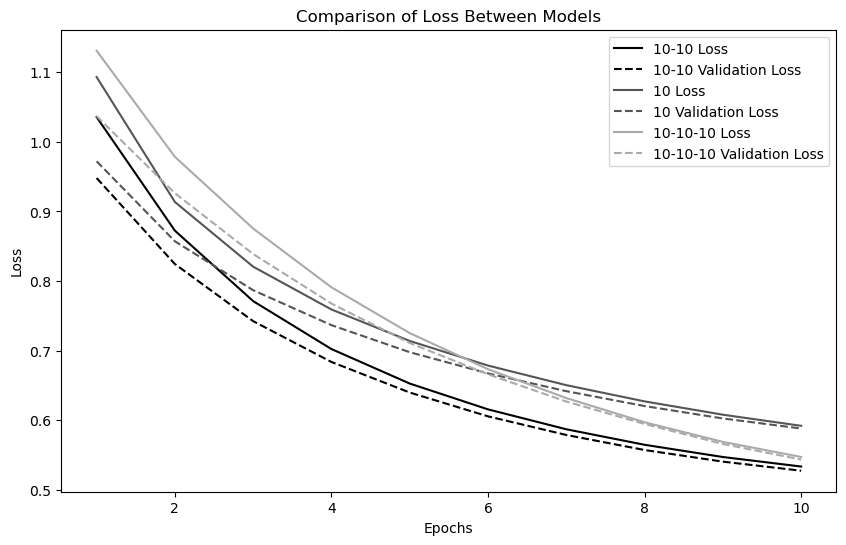

In [18]:
plot_multiple_histories({
    "10" : evaluate_params({
      "activation_function" : "elu",
      "layer_sizes" : [10]
    })[2],
    "10-10" : evaluate_params({
      "activation_function" : "elu",
      "layer_sizes" : [10, 10]
    })[2],
    "10-10-10" : evaluate_params({
      "activation_function" : "elu",
      "layer_sizes" : [10, 10, 10]
    })[2],
  },
  show_validation=True
)

# Search Approches


## Grid Search

In [19]:


def get_name(params):
  return '-'.join([str(params[key]) for key in sorted(params.keys())])

def grid_search(param_grid, verbose=1, num_epochs=10):
  
  # params_list = []
  # acc_list = []
  # history_list = []
  history_dict = {}
  for params in sklearn.model_selection.ParameterGrid(param_grid):
    print(f"params: {params}")
    pars, acc, history = evaluate_params(params, verbose=verbose, num_epochs=num_epochs)
    
    # params_list.append(pars)
    # acc_list.append(acc)
    # history_list.append(history)
    history_dict[get_name(pars)] = history
  
  return history_dict

params: {'activation_function': 'elu', 'batch_size': 128, 'layer_sizes': [10]}
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2923 - loss: 1.2983 - val_accuracy: 0.3697 - val_loss: 1.1592
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4293 - loss: 1.0940 - val_accuracy: 0.4721 - val_loss: 1.0215
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5100 - loss: 0.9880 - val_accuracy: 0.5682 - val_loss: 0.9279
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6046 - loss: 0.9048 - val_accuracy: 0.6438 - val_loss: 0.8594
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6467 - loss: 0.8458 - val_accuracy: 0.6891 - val_loss: 0.8066
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6963 - loss: 0.7947 - val_accuracy: 0.7244 - val_loss: 0.7646
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7215 - loss: 0.7538 - val_accuracy: 0.7493 - val_loss: 0.7302
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 

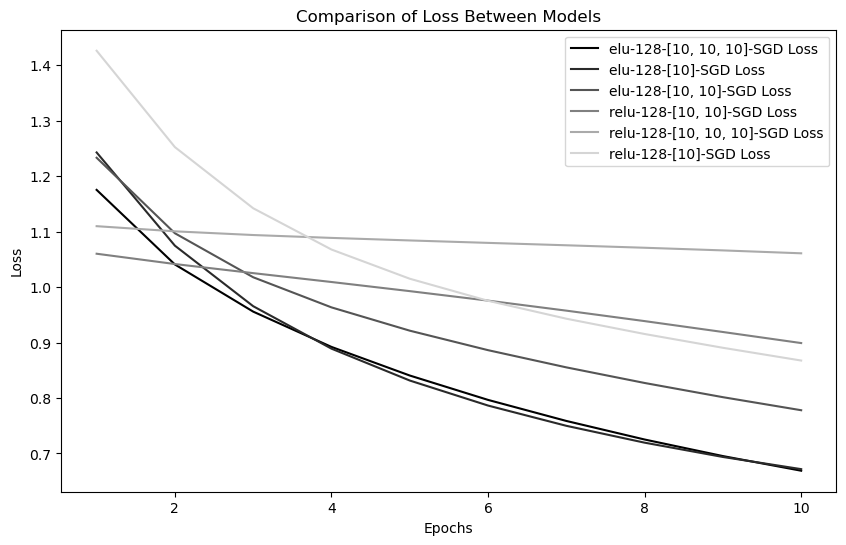

In [20]:
history_dict = grid_search(
  param_grid={
    "activation_function" : ["elu", "relu"],
    "layer_sizes" : [[10], [10, 10], [10,10,10]],
    "batch_size" : [128]
  },
  # num_epochs=100
)
plot_multiple_histories(history_dict)

## Random Search

In [21]:
def random_search(param_grid, num_tests=5, random_state=None, verbose=1, num_epochs=10):
  
  # create a list of unique parameter combinations
  param_combs = list(sklearn.model_selection.ParameterGrid(param_grid))
  if len(param_combs) < num_tests:
    num_tests = len(param_combs)
  random_combs = np.random.choice(param_combs, size=num_tests,
    replace=False)
  
  # evaluate each of the combinations
  history_dict = {}
  for params in random_combs:
    print(f"params: {params}")
    pars, acc, history = evaluate_params(params, verbose=verbose, num_epochs=num_epochs)
    
    history_dict[get_name(pars)] = history
  
  return history_dict


params: {'activation_function': 'relu', 'batch_size': 128, 'layer_sizes': [10]}
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4096 - loss: 1.3004 - val_accuracy: 0.4328 - val_loss: 1.2128
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4494 - loss: 1.1780 - val_accuracy: 0.4587 - val_loss: 1.1259
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4611 - loss: 1.1098 - val_accuracy: 0.4791 - val_loss: 1.0635
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4943 - loss: 1.0366 - val_accuracy: 0.4975 - val_loss: 1.0153
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5138 - loss: 0.9894 - val_accuracy: 0.5134 - val_loss: 0.9763
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5416 - loss: 0.9484 - val_accuracy: 0.5284 - val_loss: 0.9435
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5623 - loss: 0.9206 - val_accuracy: 0.5468 - val_loss: 0.9150
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 

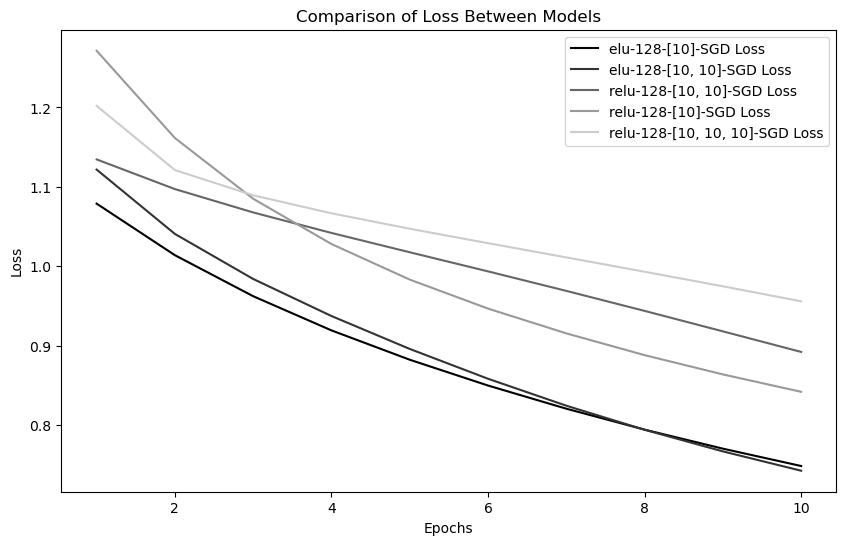

In [22]:
 history_dict = random_search(
  param_grid={
    "activation_function" : ["elu", "relu"],
    "layer_sizes" : [[10], [10, 10], [10,10,10]],
    "batch_size" : [128]
  }
)
plot_multiple_histories(history_dict, sort_key="accuracy")

params: {'activation_function': 'elu', 'batch_size': 128, 'layer_sizes': [2]}
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4995 - loss: 1.0101 - val_accuracy: 0.5040 - val_loss: 0.9922
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5385 - loss: 0.9649 - val_accuracy: 0.5323 - val_loss: 0.9525
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5682 - loss: 0.9319 - val_accuracy: 0.5607 - val_loss: 0.9199
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5981 - loss: 0.8987 - val_accuracy: 0.5836 - val_loss: 0.8926
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6046 - loss: 0.8822 - val_accuracy: 0.6020 - val_loss: 0.8695
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6201 - loss: 0.8569 - val_accuracy: 0.6164 - val_loss: 0.8497
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6333 - loss: 0.8401 - val_accuracy: 0.6259 - val_loss: 0.8326
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0

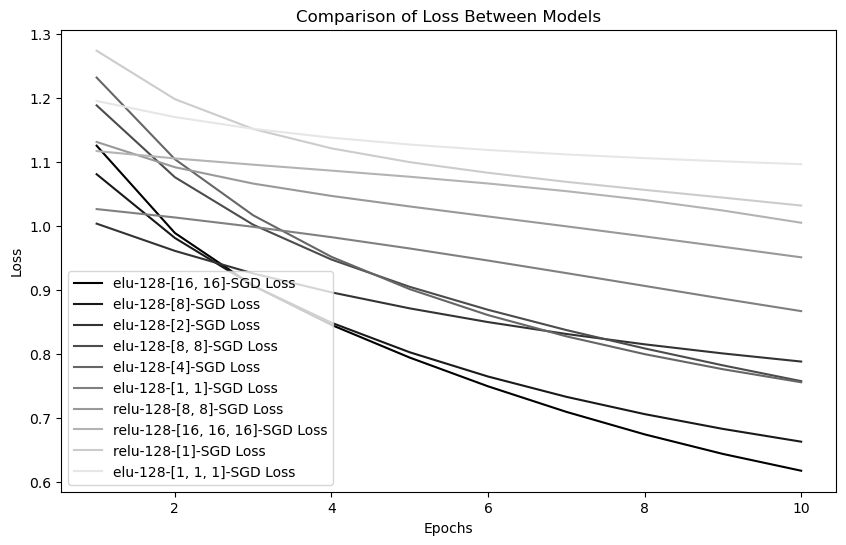

In [23]:
history_dict = random_search(
  param_grid={
    "activation_function" : ["elu", "relu"],
    "layer_sizes" : [[2**layer_size] * num_layers for layer_size in range(0,5) for num_layers in range(0,4)],
    "batch_size" : [128]
  },
  # num_epochs=200,
  num_tests=10
)

plot_multiple_histories(history_dict)

## Grid Search with logger

In [24]:
import logging

class TuningLogger:
  default_log_dir = "logs/"
  
  def __init__(self, log_dir=None):
    
    current_time = datetime.datetime.now()
    self.id = current_time.strftime("%d%b%Y-%H-%M-%S-%f")   # hour, minute, microseconds
    
    self.logger = logging.getLogger("TuningLogger")
    self.logger.setLevel(logging.INFO)
    
    if self.logger.hasHandlers():
      self.logger.handlers.clear()
    self.logger.propagate = False
    
    
    if log_dir is None:
      log_dir = self.__class__.default_log_dir
      
    if not os.path.exists(log_dir):
      os.mkdir(log_dir)
    
    log_path = os.path.join(log_dir, f"{self.__class__.__name__}-{self.id}.log")
    
    file_handler = logging.FileHandler(log_path)
    file_handler.setFormatter(logging.Formatter('%(message)s'))
    self.logger.addHandler(file_handler)
  
  def log_trial(self, params, history, metrics=["loss"], agg_history=3):
    report = {
      "id": self.id,
      "time": time.time(), # time since epoch
    }
    report.update(params)
    for metric in metrics:
      report[metric] = np.mean(history.history[metric][:-agg_history])
    self.logger.info(report)
    return


In [25]:

def grid_search_logging(param_grid, verbose=1, num_epochs=10, log_results=True):
  
  tuning_logger = TuningLogger()
  
  history_dict = {}
  for params in sklearn.model_selection.ParameterGrid(param_grid):
    print(f"params: {params}")
    pars, acc, history = evaluate_params(params, verbose=verbose, num_epochs=num_epochs)
    if log_results:
      tuning_logger.log_trial(pars, history)
    history_dict[get_name(pars)] = history
  
  return history_dict
  


In [ ]:
history_dict = grid_search_logging(
  param_grid={
    "activation_function" : ["elu"], #["elu", "relu"],
    "layer_sizes" : [[2**layer_size] * num_layers for layer_size in range(3,5) for num_layers in range(2,4)],
    "batch_size" : [2**batch_exponent for batch_exponent in range(8,11)]
  },
  num_epochs=400
)
plot_multiple_histories(history_dict)

params: {'activation_function': 'elu', 'batch_size': 256, 'layer_sizes': [8, 8]}
Epoch 1/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3104 - loss: 1.2992 - val_accuracy: 0.3378 - val_loss: 1.2290
Epoch 2/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3289 - loss: 1.2363 - val_accuracy: 0.3751 - val_loss: 1.1657
Epoch 3/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3776 - loss: 1.1672 - val_accuracy: 0.4080 - val_loss: 1.1141
Epoch 4/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4045 - loss: 1.1119 - val_accuracy: 0.4383 - val_loss: 1.0705
Epoch 5/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4263 - loss: 1.0755 - val_accuracy: 0.4761 - val_loss: 1.0321
Epoch 6/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4723 - loss: 1.0278 - val_accuracy: 0.5109 - val_loss: 0.9978
Epoch 7/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4944 - loss: 1.0035 - val_accuracy: 0.5413 - val_loss: 0.9662
Epoch 8/400
19/19 ━━━━━━━━━━━

# Optuna

In [31]:
import optuna

In [32]:

def objective(trial):
  # params = default_params
  
  layer_size = trial.suggest_int("layer_size", 3, 5)
  num_layers = trial.suggest_int("num_layers", 2, 4)
  batch_exponent = trial.suggest_int("batch_exponent", 2, 8)
  params = {
    "activation_function" : trial.suggest_categorical("activation", ["elu"]),
    "layer_sizes" : [2**layer_size for _ in range(num_layers)],
    "batch_size" : 2**batch_exponent
  }
  pars, acc, history = evaluate_params(params)
  return acc
  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

best_trial = study.best_trial
print(best_trial.values[0])
print(best_trial.params)


[I 2024-10-13 18:16:14,957] A new study created in memory with name: no-name-77224289-c010-4c10-ab3b-2f66467a55a0


Epoch 1/10
587/587 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6865 - loss: 0.7811 - val_accuracy: 0.8264 - val_loss: 0.5046
Epoch 2/10
345/587 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8325 - loss: 0.4954

[W 2024-10-13 18:16:22,713] Trial 0 failed with parameters: {'layer_size': 5, 'num_layers': 3, 'batch_exponent': 3, 'activation': 'elu'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/ssogden/miniconda3/envs/cst463/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/qh/wybqz5g16cl72p8y8_w08npr0000gn/T/ipykernel_41510/2370874609.py", line 12, in objective
    pars, acc, history = evaluate_params(params)
  File "/var/folders/qh/wybqz5g16cl72p8y8_w08npr0000gn/T/ipykernel_41510/74133088.py", line 23, in evaluate_params
    history = model.fit(
  File "/Users/ssogden/miniconda3/envs/cst463/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/Users/ssogden/miniconda3/envs/cst463/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
    logs =

KeyboardInterrupt: 